In [1]:
cd ..

c:\Users\auror\New_VAES\VAEs


In [64]:
import torch
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random
from src.useful_functions import *

In [65]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(-math.pi,math.pi)
#p_x = torch.distributions.exponential.Exponential(0.5)
#p_x = torch.distributions.normal.Normal(math.pi, (math.pi)/2)
#Training parameters
N_EPOCHS = 100
N_SAMPLES = 5000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

Text(0, 0.5, 'Encoding')

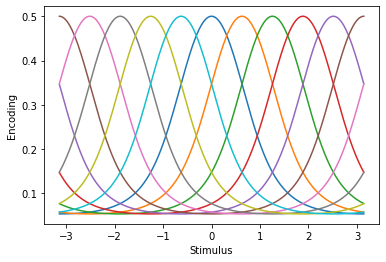

In [66]:
#CIRCULAR ENCODER
enc_circ = CircularBernoulliEncoder(N)
dec = MLPDecoder_circ(N,200)
r = enc_circ.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [67]:
#Modified Bessel function (to compute distortion)

class ModifiedBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, k, nu):
        ctx._nu = nu
        ctx.save_for_backward(k)
        return torch.from_numpy(scipy.special.iv(nu, k.detach().numpy()))
    @staticmethod
    def backward(ctx, grad_out):
        k, = ctx.saved_tensors
        nu = ctx._nu
        
        return 0.5* grad_out *(ModifiedBessel.apply(k, nu - 1.0)+ModifiedBessel.apply(k, nu + 1.0)), None

modified_bessel = ModifiedBessel.apply


#Circular distortion

def distortion_circular(x,encoder,decoder,lat_samp=10,tau=0.5):
    #Logit r|x
    l_r_x = encoder(x)
    bsize,N = l_r_x.shape
    #ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
    eps = torch.rand(bsize,lat_samp,N)
    r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/tau)
    mu_dec,log_k = decoder(r)
    log_k =2.29*torch.ones(1)
    #k = 1/sigma2_dec
    logq_x_r = torch.exp(log_k)*torch.cos(x-mu_dec) - torch.log(modified_bessel(torch.exp(log_k),0)) - torch.log(2*torch.as_tensor(math.pi))
    D = -logq_x_r.mean()
    return D

In [68]:
q = rate_ising(N)
rate = q(enc_circ,x_fine)
dist = distortion_circular(x_fine,enc_circ,dec)

In [78]:
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = itertools.chain(dec.parameters())
lr = 1e-2
opt = torch.optim.Adam(params,lr)
lossVec = []
rateVec = []
distVec = []
for epoch in range(200):
    for x_ in x_data:
        #rate = q(enc_circ,x_)
        dist = distortion_circular(x_,enc_circ,dec)
        loss = dist # + rate
        print(enc_circ.log_ks)
        opt.zero_grad()
        loss.backward()
        opt.step()

        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())

Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parameter containing:
tensor([[1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579, 1.1579,
         1.1579]], requires_grad=True)
Parame

Text(0, 0.5, 'Encoding')

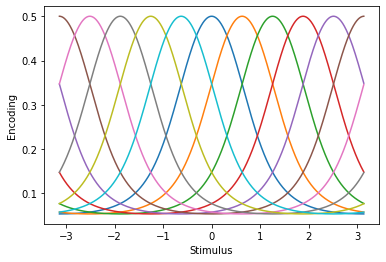

In [56]:
plt.plot(x_fine,torch.sigmoid(enc_circ(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")
#plt.xlim(-math.pi, math.pi)

c:\Users\auror\New_VAES\VAEs\src\encoders_decoders.py:271: UserWarning: Output 0 of SqueezeBackward0 is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  ..\torch\csrc\autograd\variable.cpp:547.)
  sigma2_dec[sigma2_dec<0] = torch.sqrt(sigma2_dec[sigma2_dec<0]**2)


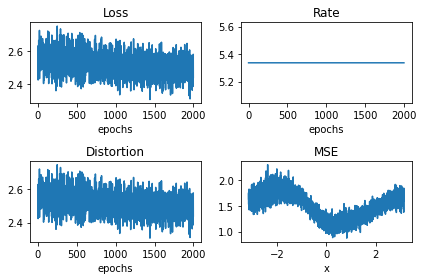

In [57]:
r = enc_circ.sample(x_sorted,50)
x_dec = dec.sample(r,50)
mseVec = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('epochs')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[0, 1].set_xlabel('epochs')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 0].set_xlabel('epochs')
axs[1, 1].plot(x_sorted,mseVec)
axs[1, 1].set_title('MSE')
axs[1, 1].set_xlabel('x')
fig.tight_layout()


In [73]:
x_dec.shape
x_sorted.shape
a = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))
b = 2 - 2*torch.cos((x_dec - x_sorted[None,:]).mean(dim=(0,2)))
a.shape
b.shape


torch.Size([5000])

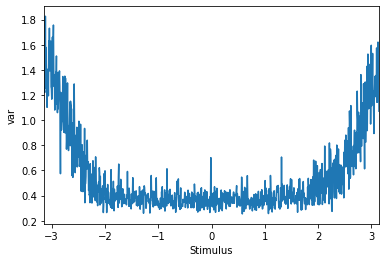

In [74]:
r= enc_circ.sample(x_fine,15)
mu_dec,sigma2_dec = dec(r)
x_ext = dec.sample(r,10)

#variance of the decoder through the stimulus space
with torch.no_grad():
    plt.plot(x_fine,torch.sqrt(sigma2_dec.mean(dim=1)))
    plt.ylabel("var")
    plt.xlabel("Stimulus")
    plt.xlim(-math.pi,math.pi)

(-3.141592653589793, 3.141592653589793)

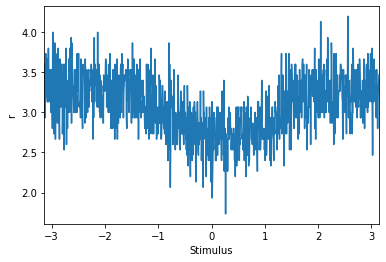

In [75]:
#Probability of each neuron to be active. The x axis is the stimulus space
plt.plot(x_fine,r.sum(dim=2).mean(dim=1))
plt.ylabel("r")
plt.xlabel("Stimulus")
plt.xlim(-math.pi,math.pi)

(-3.141592653589793, 3.141592653589793)

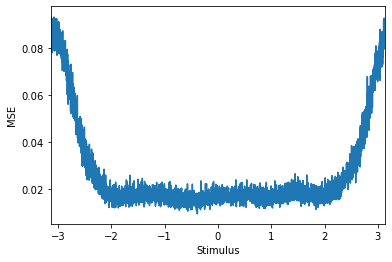

In [76]:
#Mean squared error

r = enc_circ.sample(x_sorted,100)
x_dec = dec.sample(r,100)


mseVec = 2 - 2*torch.cos((x_dec - x_sorted[None,:])).mean(dim=(0,2))
plt.plot(x_sorted,mseVec.detach()/20)
plt.ylabel("MSE")
plt.xlabel("Stimulus")
plt.xlim(-math.pi,math.pi)


In [28]:
x_ext.shape

torch.Size([10, 1000, 15])

In [79]:
l_r_x = enc_circ(x_fine)
bsize,N = l_r_x.shape
#ALERT: Gumbel Softmax trick (TO DEEPEN ALSO FOR THE THESIS)
eps = torch.rand(bsize,15,N)
r = torch.sigmoid((torch.log(eps) - torch.log(1-eps) + l_r_x[:,None,:])/0.1)
mu_dec,log_k = dec(r)
log_k =2.29*torch.ones(1)
logq_x_r = torch.exp(log_k)*torch.cos(x_fine-mu_dec[0,:]) - torch.log(modified_bessel(torch.exp(log_k),0)) - torch.log(2*torch.as_tensor(math.pi))

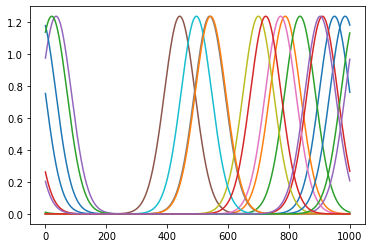

In [80]:
plt.plot(torch.exp(logq_x_r.detach()))

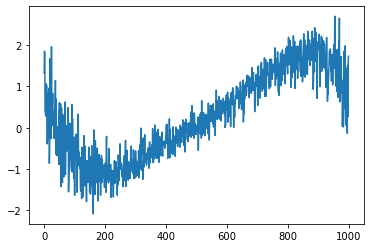

In [81]:
plt.plot(mu_dec.mean(dim=1).detach())

In [42]:
log_k[0,0]

tensor(2.2985, grad_fn=<SelectBackward>)